In [1]:
!pip install h5py scikit-learn scipy matplotlib

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import seaborn as sns
import sys
import math
import pickle
import h5py
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve, auc
from sklearn.utils import shuffle
from sklearn.cluster import KMeans
from sklearn.preprocessing import label_binarize

Train data is loaded!
Epoch 1, Cost: 5.612977840332315, Accuracy: 0.3117572156196944
Epoch 2, Cost: 2.779118067025274, Accuracy: 0.764855687606112
Epoch 3, Cost: 2.6597387552261353, Accuracy: 0.5611205432937182
Epoch 4, Cost: 1.2325418407097453, Accuracy: 0.8962224108658744
Epoch 5, Cost: 0.9618688667658717, Accuracy: 0.8875212224108658
Epoch 6, Cost: 1.5605543514713305, Accuracy: 0.492572156196944
Epoch 7, Cost: 2.1262406477704645, Accuracy: 0.8289473684210527
Epoch 8, Cost: 1.5426796616902991, Accuracy: 0.8588709677419355
Epoch 9, Cost: 1.4343724250784817, Accuracy: 0.8885823429541596
Epoch 10, Cost: 1.5665084283798927, Accuracy: 0.5581494057724957
Epoch 11, Cost: 0.6479786608868516, Accuracy: 0.8826400679117148
Epoch 12, Cost: 0.83389734376874, Accuracy: 0.8991935483870968
Epoch 13, Cost: 0.7704234326655943, Accuracy: 0.7145585738539898
Epoch 14, Cost: 1.0262481135769577, Accuracy: 0.8991935483870968
Epoch 15, Cost: 0.6121794240397435, Accuracy: 0.8896434634974533
Epoch 16, Cost: 0.

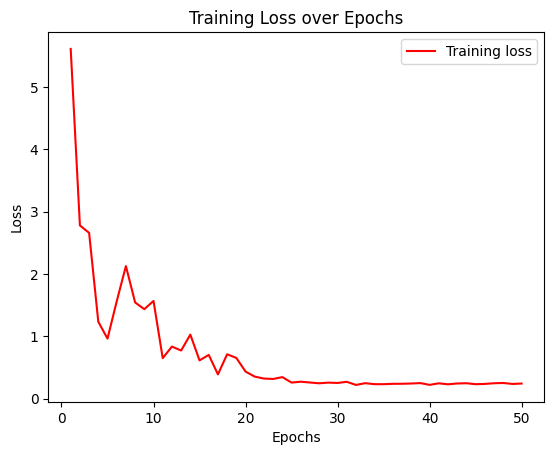

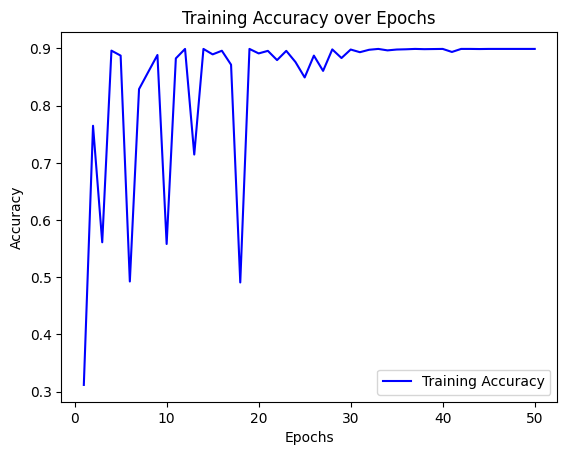

In [4]:
# TLSTM 모델 클래스
class TLSTM(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, fc_dim, train=True):
        super(TLSTM, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        # Weight Initialization
        if train:
            self.Wi = nn.Parameter(torch.randn(input_dim, hidden_dim) * 0.1)
            self.Ui = nn.Parameter(torch.randn(hidden_dim, hidden_dim) * 0.1)
            self.bi = nn.Parameter(torch.ones(hidden_dim))

            self.Wf = nn.Parameter(torch.randn(input_dim, hidden_dim) * 0.1)
            self.Uf = nn.Parameter(torch.randn(hidden_dim, hidden_dim) * 0.1)
            self.bf = nn.Parameter(torch.ones(hidden_dim))

            self.Wog = nn.Parameter(torch.randn(input_dim, hidden_dim) * 0.1)
            self.Uog = nn.Parameter(torch.randn(hidden_dim, hidden_dim) * 0.1)
            self.bog = nn.Parameter(torch.ones(hidden_dim))

            self.Wc = nn.Parameter(torch.randn(input_dim, hidden_dim) * 0.1)
            self.Uc = nn.Parameter(torch.randn(hidden_dim, hidden_dim) * 0.1)
            self.bc = nn.Parameter(torch.ones(hidden_dim))

            self.W_decomp = nn.Parameter(torch.randn(hidden_dim, hidden_dim) * 0.1)
            self.b_decomp = nn.Parameter(torch.ones(hidden_dim))

            self.Wo = nn.Parameter(torch.randn(fc_dim, hidden_dim) * 0.1)
            self.bo = nn.Parameter(torch.ones(fc_dim))

            self.W_softmax = nn.Parameter(torch.randn(output_dim, fc_dim) * 0.1)
            self.b_softmax = nn.Parameter(torch.ones(output_dim))

    def forward(self, inputs, times, keep_prob=0.5):
        batch_size, seq_len, _ = inputs.size()

        initial_hidden = torch.zeros(batch_size, self.hidden_dim)
        initial_cell = torch.zeros(batch_size, self.hidden_dim)
        prev_hidden_memory = (initial_hidden, initial_cell)

        all_states = []

        for t in range(seq_len):
            concat_input = torch.cat([times[:, t].unsqueeze(1), inputs[:, t]], dim=1)
            prev_hidden_memory = self.TLSTM_Unit(prev_hidden_memory, concat_input)
            all_states.append(prev_hidden_memory[0])  # hidden state

        all_states = torch.stack(all_states, dim=1)
        final_state = all_states[:, -1, :]  # Get the last hidden state

        output = F.relu(F.linear(final_state, self.Wo, self.bo))
        output = F.dropout(output, p=keep_prob, training=self.training)

        logits = F.linear(output, self.W_softmax, self.b_softmax)

        return logits

    def TLSTM_Unit(self, prev_hidden_memory, concat_input):
        prev_hidden_state, prev_cell = prev_hidden_memory
        x = concat_input[:, 1:]
        t = concat_input[:, :1]

        T = self.map_elapse_time(t)

        C_ST = torch.tanh(torch.mm(prev_cell, self.W_decomp) + self.b_decomp)
        C_ST_dis = T * C_ST
        prev_cell = prev_cell - C_ST + C_ST_dis

        i = torch.sigmoid(torch.mm(x, self.Wi) + torch.mm(prev_hidden_state, self.Ui) + self.bi)
        f = torch.sigmoid(torch.mm(x, self.Wf) + torch.mm(prev_hidden_state, self.Uf) + self.bf)
        o = torch.sigmoid(torch.mm(x, self.Wog) + torch.mm(prev_hidden_state, self.Uog) + self.bog)
        C = torch.tanh(torch.mm(x, self.Wc) + torch.mm(prev_hidden_state, self.Uc) + self.bc)
        Ct = f * prev_cell + i * C
        current_hidden_state = o * torch.tanh(Ct)

        return current_hidden_state, Ct

    def map_elapse_time(self, t):
        c1 = torch.tensor(1.0)
        c2 = torch.tensor(2.7183)
        T = c1 / torch.log(t + c2)
        Ones = torch.ones(1, self.hidden_dim)
        T = T @ Ones
        return T

# 파일 로드
def load_pkl(path):
    with open(path, 'rb') as f:
        obj = pickle.load(f, encoding='latin1')
    return obj

# ROC Curve
def plot_roc_curve(Y_true, Logits):
    if len(Y_true.shape) == 1 or Y_true.shape[1] == 1:
        Y_true = label_binarize(Y_true, classes=[0, 1])

    class_1_probs = Logits[:, 1]
    fpr, tpr, _ = roc_curve(Y_true.ravel(), class_1_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

# Confusion Matrix
def plot_confusion_matrix(Y_true, Y_pred):
    cm = confusion_matrix(Y_true, Y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

# Training
train_losses = []
train_accuracies = []

def training(path, learning_rate, training_epochs, train_dropout_prob, hidden_dim, fc_dim, model_path):
    data_train_batches = load_pkl(f'{path}/data_train.pkl')
    elapsed_train_batches = load_pkl(f'{path}/elapsed_train.pkl')
    labels_train_batches = load_pkl(f'{path}/label_train.pkl')

    number_train_batches = len(data_train_batches)
    print("Train data is loaded!")

    input_dim = data_train_batches[0].shape[2]
    output_dim = labels_train_batches[0].shape[1]

    lstm = TLSTM(input_dim, output_dim, hidden_dim, fc_dim)
    optimizer = optim.Adam(lstm.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    lstm.train()

    for epoch in range(training_epochs):
        total_cost = 0
        correct_predictions = 0
        total_samples = 0

        for i in range(number_train_batches):
            batch_xs, batch_ys, batch_ts = data_train_batches[i], labels_train_batches[i], elapsed_train_batches[i]
            batch_ts = np.reshape(batch_ts, [batch_ts.shape[0], batch_ts.shape[2]])

            batch_xs = torch.tensor(batch_xs, dtype=torch.float32)
            batch_ys = torch.tensor(batch_ys, dtype=torch.long)
            batch_ts = torch.tensor(batch_ts, dtype=torch.float32)

            optimizer.zero_grad()

            logits = lstm(batch_xs, batch_ts, train_dropout_prob)
            loss = criterion(logits, batch_ys.argmax(dim=1))
            loss.backward()
            optimizer.step()

            total_cost += loss.item()

            y_pred = torch.argmax(logits, dim=1)
            correct_predictions += (y_pred == batch_ys.argmax(dim=1)).sum().item()
            total_samples += batch_ys.size(0)

        avg_loss = total_cost / number_train_batches
        accuracy = correct_predictions / total_samples
        train_losses.append(avg_loss)
        train_accuracies.append(accuracy)

        print(f"Epoch {epoch + 1}, Cost: {avg_loss}, Accuracy: {accuracy}")

    torch.save(lstm.state_dict(), model_path)
    print("Model saved!")

# Test
def testing(path, hidden_dim, fc_dim, model_path):
    data_test_batches = load_pkl(f'{path}/data_test.pkl')
    elapsed_test_batches = load_pkl(f'{path}/elapsed_test.pkl')
    labels_test_batches = load_pkl(f'{path}/label_test.pkl')

    number_test_batches = len(data_test_batches)
    print("Test data is loaded!")

    input_dim = data_test_batches[0].shape[2]
    output_dim = labels_test_batches[0].shape[1]

    lstm = TLSTM(input_dim, output_dim, hidden_dim, fc_dim)
    lstm.load_state_dict(torch.load(model_path))
    lstm.eval()

    Y_true = []
    Y_pred = []
    Labels = []
    Logits = []

    with torch.no_grad():
        for i in range(number_test_batches):
            batch_xs, batch_ys, batch_ts = data_test_batches[i], labels_test_batches[i], elapsed_test_batches[i]
            batch_ts = np.reshape(batch_ts, [batch_ts.shape[0], batch_ts.shape[2]])

            batch_xs = torch.tensor(batch_xs, dtype=torch.float32)
            batch_ys = torch.tensor(batch_ys, dtype=torch.long)
            batch_ts = torch.tensor(batch_ts, dtype=torch.float32)

            logits = lstm(batch_xs, batch_ts, 1.0)
            y_pred = torch.argmax(logits, dim=1)

            Y_true.append(batch_ys.argmax(dim=1).numpy())
            Y_pred.append(y_pred.numpy())
            Labels.append(batch_ys.numpy())
            Logits.append(logits.numpy())

    # numpy 배열
    Y_true = np.concatenate(Y_true, axis=0)
    Y_pred = np.concatenate(Y_pred, axis=0)
    Labels = np.concatenate(Labels, axis=0)
    Logits = np.concatenate(Logits, axis=0)

    print(f"Y_true length: {len(Y_true)}, Logits length: {len(Logits)}")

    total_acc = accuracy_score(Y_true, Y_pred)
    total_auc = roc_auc_score(Labels, Logits, average='micro')
    total_auc_macro = roc_auc_score(Labels, Logits, average='macro')

    print(f"Test Accuracy = {total_acc:.3f}")
    print(f"Test AUC Micro = {total_auc:.3f}")
    print(f"Test AUC Macro = {total_auc_macro:.3f}")

    return Y_true, Y_pred, Logits

# Result Plot
def plot_training_results():
    epochs = range(1, len(train_losses) + 1)

    # Loss
    plt.figure()
    plt.plot(epochs, train_losses, 'r', label='Training loss')
    plt.title('Training Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Accuracy
    plt.figure()
    plt.plot(epochs, train_accuracies, 'b', label='Training Accuracy')
    plt.title('Training Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

def main():
    training_mode = 1  # 1이면 학습, 0이면 테스트 모드
    path = '/content/drive/MyDrive/신경미분방정식/PaperPresentation/Spilt0'

    if training_mode == 1:
        # Train
        learning_rate = 0.001
        training_epochs = 50
        dropout_prob = 0.5
        hidden_dim = 1028  #
        fc_dim = 512
        model_path = '/content/drive/MyDrive/신경미분방정식/PaperPresentation/model_checkpoint1.pth'
        training(path, learning_rate, training_epochs, dropout_prob, hidden_dim, fc_dim, model_path)
        plot_training_results()
    else:
        # Test
        hidden_dim = 1028
        fc_dim = 512
        model_path = '/content/drive/MyDrive/신경미분방정식/PaperPresentation/model_checkpoint1.pth'
        Y_true, Y_pred, Logits = testing(path, hidden_dim, fc_dim, model_path)

        # plot_roc_curve(Y_true, Logits)
        # plot_confusion_matrix(Y_true, Y_pred)

if __name__ == "__main__":
    main()


Test data is loaded!


<ipython-input-4-30e0e803d08a>:194: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lstm.load_state_dict(torch.load(model_path))


Y_true length: 2018, Logits length: 2018
Test Accuracy = 0.900
Test AUC Micro = 0.913
Test AUC Macro = 0.771


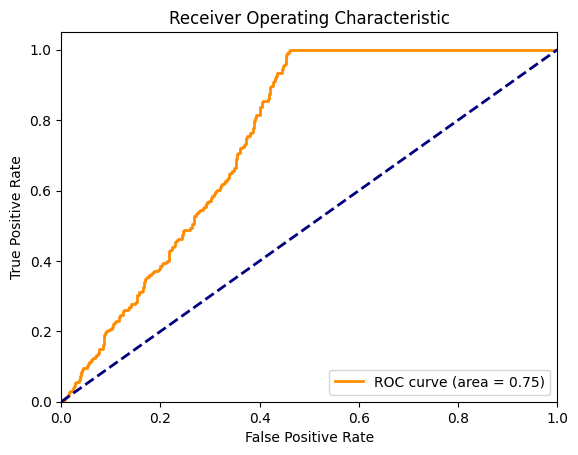

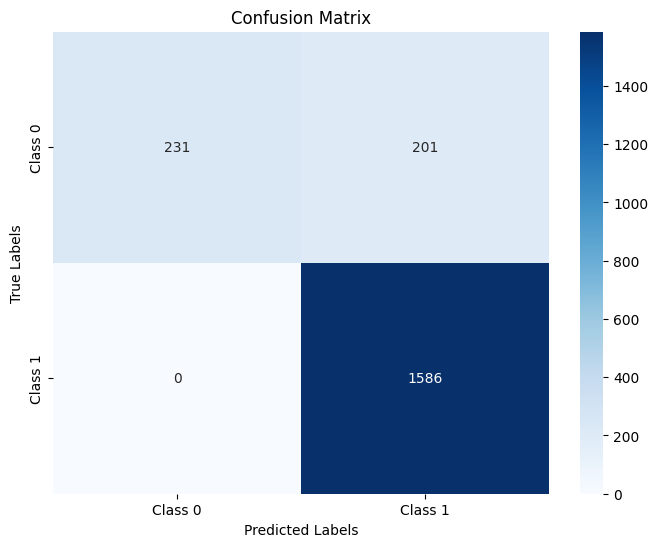

In [6]:
path = '/content/drive/MyDrive/신경미분방정식/PaperPresentation/Spilt0'
hidden_dim = 1028
fc_dim = 512
model_path = '/content/drive/MyDrive/신경미분방정식/PaperPresentation/model_checkpoint1.pth'

# ROC Curve
Y_true, Y_pred, Logits = testing(path, hidden_dim, fc_dim, model_path)
plot_roc_curve(Y_true, Logits)

# Confusion Matrix
plot_confusion_matrix(Y_true, Y_pred)



In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class T_LSTM_AE(nn.Module):
    def __init__(self, input_dim, output_dim, output_dim2, output_dim3, hidden_dim, hidden_dim2, hidden_dim3):
        super(T_LSTM_AE, self).__init__()

        self.input_dim = input_dim
        self.output_dim = output_dim
        self.output_dim2 = output_dim2
        self.output_dim3 = output_dim3
        self.hidden_dim = hidden_dim
        self.hidden_dim2 = hidden_dim2
        self.hidden_dim3 = hidden_dim3

        # Encoder weights
        self.Wq_enc = nn.Linear(3, hidden_dim)
        self.Wi_enc = nn.Linear(input_dim, hidden_dim)
        self.Ui_enc = nn.Linear(hidden_dim, hidden_dim)
        self.bi_enc = nn.Parameter(torch.zeros(hidden_dim))

        self.W_decomp_enc = nn.Linear(hidden_dim, hidden_dim)
        self.b_decomp_enc = nn.Parameter(torch.zeros(hidden_dim))

        # Decoder weights
        self.Wi_dec = nn.Linear(hidden_dim, hidden_dim2)
        self.Ui_dec = nn.Linear(hidden_dim2, hidden_dim2)
        self.bi_dec = nn.Parameter(torch.zeros(hidden_dim2))

        self.W_decomp_dec = nn.Linear(hidden_dim2, hidden_dim2)
        self.b_decomp_dec = nn.Parameter(torch.zeros(hidden_dim2))

        self.Wo = nn.Linear(hidden_dim2, output_dim3)
        self.bo = nn.Parameter(torch.zeros(output_dim3))

    def forward(self, x, time, keep_prob=0.5):
        batch_size, seq_len, input_dim = x.size()

        # Initialize hidden states and cell states
        h = torch.zeros(batch_size, self.hidden_dim).to(x.device)
        c = torch.zeros(batch_size, self.hidden_dim).to(x.device)

        # Encoder forward pass
        for t in range(seq_len):
            x_t = x[:, t, :]  # (batch_size, input_dim)
            time_t = time[:, t].unsqueeze(1)  # (batch_size, 1)

            # Time mapping and cell state decomposition
            T = self.map_elapse_time(time_t, self.hidden_dim)
            c = self.time_decomposition(c, T, self.W_decomp_enc, self.b_decomp_enc)

            # Input gate
            i = torch.sigmoid(self.Wi_enc(x_t) + self.Ui_enc(h) + self.bi_enc)
            # Candidate memory cell
            C_tilde = torch.tanh(self.Wi_enc(x_t) + self.Ui_enc(h) + self.bi_enc)
            # Update cell state
            c = i * C_tilde + (1 - i) * c
            # Hidden state update
            h = torch.tanh(c)

        # Decoder initial state
        h_dec = torch.zeros(batch_size, self.hidden_dim2).to(x.device)
        c_dec = torch.zeros(batch_size, self.hidden_dim2).to(x.device)

        # Decoder forward pass (reconstructing output sequence)
        outputs = []
        for t in range(seq_len):
            # Time mapping and cell state decomposition in decoder
            T_dec = self.map_elapse_time(time_t, self.hidden_dim2)
            c_dec = self.time_decomposition(c_dec, T_dec, self.W_decomp_dec, self.b_decomp_dec)

            # Input gate for decoder
            i_dec = torch.sigmoid(self.Wi_dec(h) + self.Ui_dec(h_dec) + self.bi_dec)
            C_tilde_dec = torch.tanh(self.Wi_dec(h) + self.Ui_dec(h_dec) + self.bi_dec)

            # Update decoder cell state and hidden state
            c_dec = i_dec * C_tilde_dec + (1 - i_dec) * c_dec
            h_dec = torch.tanh(c_dec)

            # Generate output
            output = self.Wo(h_dec) + self.bo
            outputs.append(output.unsqueeze(1))

        # Concatenate all outputs (batch_size, seq_len, output_dim3)
        outputs = torch.cat(outputs, dim=1)

        return outputs


    def map_elapse_time(self, t, dim):
        c1 = torch.tensor(1.0, dtype=torch.float32, device=t.device)
        c2 = torch.tensor(2.7183, dtype=torch.float32, device=t.device)
        T = c1 / torch.log(t + c2)
        Ones = torch.ones(1, dim, dtype=torch.float32, device=t.device)
        T = torch.matmul(T, Ones)
        return T

    def time_decomposition(self, c, T, W_decomp, b_decomp):
        # Apply the time-based decay to the cell state.
        C_ST = torch.sigmoid(W_decomp(c) + b_decomp)
        C_ST_dis = T * C_ST
        c = c - C_ST + C_ST_dis
        return c


Epoch 1/20, Loss: 0.5345580790724073
Epoch 2/20, Loss: 0.378538761820112
Epoch 3/20, Loss: 0.28550222516059875
Epoch 4/20, Loss: 0.21478432629789626
Epoch 5/20, Loss: 0.16253152063914708
Epoch 6/20, Loss: 0.13060697487422399
Epoch 7/20, Loss: 0.10989992107663836
Epoch 8/20, Loss: 0.09776408544608525
Epoch 9/20, Loss: 0.09346167956079755
Epoch 10/20, Loss: 0.09080530383757182
Epoch 11/20, Loss: 0.08997840327875954
Epoch 12/20, Loss: 0.08851172562156405
Epoch 13/20, Loss: 0.08873771982533592
Epoch 14/20, Loss: 0.08909590542316437
Epoch 15/20, Loss: 0.08834764787128993
Epoch 16/20, Loss: 0.08776580010141645
Epoch 17/20, Loss: 0.08745231692280088
Epoch 18/20, Loss: 0.08765337084020887
Epoch 19/20, Loss: 0.08688553529126304
Epoch 20/20, Loss: 0.08700814417430333


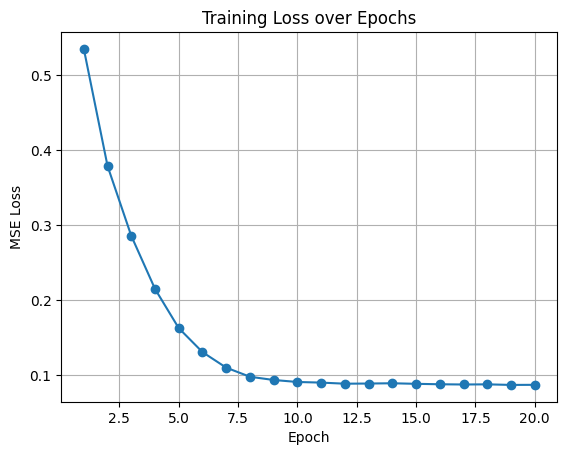

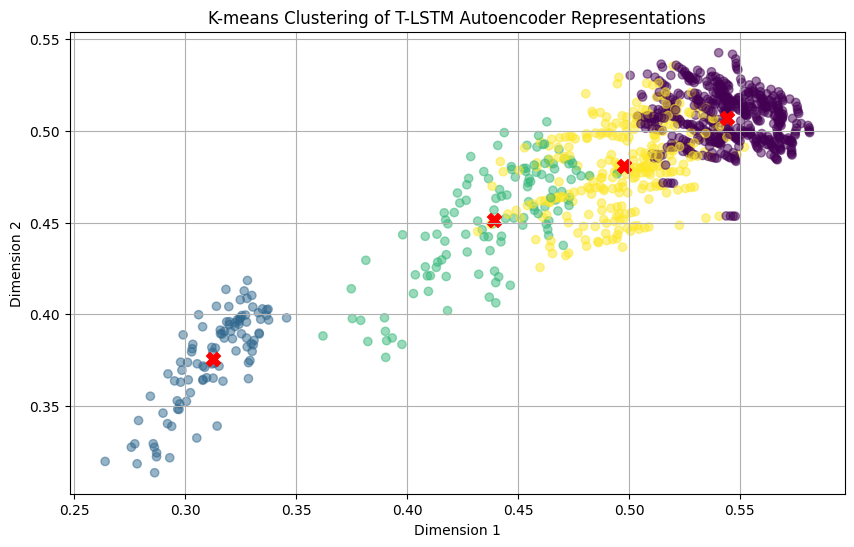

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Define the T-LSTM Autoencoder model
class T_LSTM_AE(nn.Module):
    def __init__(self, input_dim, hidden_dim, hidden_dim2, output_dim):
        super(T_LSTM_AE, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.hidden_dim2 = hidden_dim2
        self.output_dim = output_dim

        # Encoder weights
        self.Wi_enc = nn.Linear(input_dim, hidden_dim)
        self.Ui_enc = nn.Linear(hidden_dim, hidden_dim)
        self.bi_enc = nn.Parameter(torch.zeros(hidden_dim))

        self.W_decomp_enc = nn.Linear(hidden_dim, hidden_dim)
        self.b_decomp_enc = nn.Parameter(torch.zeros(hidden_dim))

        # Decoder weights
        self.Wi_dec = nn.Linear(hidden_dim, hidden_dim2)
        self.Ui_dec = nn.Linear(hidden_dim2, hidden_dim2)
        self.bi_dec = nn.Parameter(torch.zeros(hidden_dim2))

        self.W_decomp_dec = nn.Linear(hidden_dim2, hidden_dim2)
        self.b_decomp_dec = nn.Parameter(torch.zeros(hidden_dim2))

        self.Wo = nn.Linear(hidden_dim2, output_dim)
        self.bo = nn.Parameter(torch.zeros(output_dim))

    def forward(self, x, time):
        batch_size, seq_len, input_dim = x.size()

        # Initialize hidden states and cell states
        h = torch.zeros(batch_size, self.hidden_dim).to(x.device)
        c = torch.zeros(batch_size, self.hidden_dim).to(x.device)

        # Encoder forward pass
        for t in range(seq_len):
            x_t = x[:, t, :]  # (batch_size, input_dim)
            time_t = time[:, t].unsqueeze(1)  # (batch_size, 1)

            # Time mapping and cell state decomposition
            T = self.map_elapse_time(time_t, self.hidden_dim)
            c = self.time_decomposition(c, T, self.W_decomp_enc, self.b_decomp_enc)

            # Input gate
            i = torch.sigmoid(self.Wi_enc(x_t) + self.Ui_enc(h) + self.bi_enc)
            # Candidate memory cell
            C_tilde = torch.tanh(self.Wi_enc(x_t) + self.Ui_enc(h) + self.bi_enc)
            # Update cell state
            c = i * C_tilde + (1 - i) * c
            # Hidden state update
            h = torch.tanh(c)

        # Decoder initial state from encoder's last hidden state
        h_dec = torch.zeros(batch_size, self.hidden_dim2).to(x.device)
        c_dec = torch.zeros(batch_size, self.hidden_dim2).to(x.device)

        # Decoder forward pass (reconstructing output sequence)
        outputs = []
        for t in range(seq_len):
            # Use the last time_t for the entire sequence
            T_dec = self.map_elapse_time(time_t, self.hidden_dim2)
            c_dec = self.time_decomposition(c_dec, T_dec, self.W_decomp_dec, self.b_decomp_dec)

            # Input gate for decoder
            i_dec = torch.sigmoid(self.Wi_dec(h) + self.Ui_dec(h_dec) + self.bi_dec)
            C_tilde_dec = torch.tanh(self.Wi_dec(h) + self.Ui_dec(h_dec) + self.bi_dec)

            # Update decoder cell state and hidden state
            c_dec = i_dec * C_tilde_dec + (1 - i_dec) * c_dec
            h_dec = torch.tanh(c_dec)

            # Generate output
            output = self.Wo(h_dec) + self.bo
            outputs.append(output.unsqueeze(1))

        # Concatenate all outputs (batch_size, seq_len, output_dim)
        outputs = torch.cat(outputs, dim=1)

        return outputs

    def map_elapse_time(self, t, dim):
        c1 = torch.tensor(1.0, dtype=torch.float32, device=t.device)
        c2 = torch.tensor(2.7183, dtype=torch.float32, device=t.device)
        T = c1 / torch.log(t + c2)
        Ones = torch.ones(1, dim, dtype=torch.float32, device=t.device)
        T = torch.matmul(T, Ones)
        return T

    def time_decomposition(self, c, T, W_decomp, b_decomp):
        # Apply the time-based decay to the cell state.
        C_ST = torch.sigmoid(W_decomp(c) + b_decomp)
        C_ST_dis = T * C_ST
        c = c - C_ST + C_ST_dis
        return c

# Data generation (toy data)
np.random.seed(42)
torch.manual_seed(42)

# Define toy data dimensions
num_sequences = 100  # Number of sequences
sequence_length = 10  # Length of each sequence
input_dim = 6  # Number of input features

# Generate toy Data (random sequences for demonstration)
Data = np.random.rand(num_sequences, sequence_length, input_dim).astype(np.float32)
Time = np.random.randint(1, 10, size=(num_sequences, sequence_length)).astype(np.float32)

# Convert data to PyTorch tensors
Data = torch.tensor(Data)
Time = torch.tensor(Time)

# Data loader
batch_size = 16
data_loader = torch.utils.data.DataLoader(list(zip(Data, Time)), batch_size=batch_size, shuffle=True)

# Model initialization
hidden_dim = 16
hidden_dim2 = 16
output_dim = input_dim
model = T_LSTM_AE(input_dim, hidden_dim, hidden_dim2, output_dim)

# Training setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
epochs = 20
losses = []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in data_loader:
        x, t = batch
        x = x.to(device)
        t = t.to(device)

        optimizer.zero_grad()

        # Forward pass
        reconstructed = model(x, t)
        loss = criterion(reconstructed, x)
        total_loss += loss.item()

        # Backward pass
        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(data_loader)
    losses.append(avg_loss)
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss}")

# Plot the training loss
plt.plot(range(1, epochs + 1), losses, marker='o')
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.show()



# Extract representations for clustering
model.eval()
data_reps = []

with torch.no_grad():
    for x, t in zip(Data, Time):
        x = x.unsqueeze(0).to(device)
        t = t.unsqueeze(0).to(device)
        rep = model(x, t)
        data_reps.append(rep.cpu().numpy().reshape(-1, rep.shape[-1]))

data_reps = np.vstack(data_reps)


# Perform K-means clustering
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(data_reps)
centroids = kmeans.cluster_centers_

# Visualize clustering
plt.figure(figsize=(10, 6))
plt.scatter(data_reps[:, 0], data_reps[:, 1], c=kmeans.labels_, cmap='viridis', alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=100)
plt.title("K-means Clustering of T-LSTM Autoencoder Representations")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True)
plt.show()


Epoch 1/20, Loss: 0.25659526671682087
Epoch 2/20, Loss: 0.2269622938973563
Epoch 3/20, Loss: 0.20153426698275975
Epoch 4/20, Loss: 0.17171245600496018
Epoch 5/20, Loss: 0.14514237429414475
Epoch 6/20, Loss: 0.11916940765721458
Epoch 7/20, Loss: 0.10270901556525912
Epoch 8/20, Loss: 0.09735330194234848
Epoch 9/20, Loss: 0.09548181295394897
Epoch 10/20, Loss: 0.09450242561953408
Epoch 11/20, Loss: 0.09321069504533495
Epoch 12/20, Loss: 0.09295083688838142
Epoch 13/20, Loss: 0.09182607701846532
Epoch 14/20, Loss: 0.09096083790063858
Epoch 15/20, Loss: 0.09058865479060582
Epoch 16/20, Loss: 0.08932187195335116
Epoch 17/20, Loss: 0.08912099578550883
Epoch 18/20, Loss: 0.08923311212233134
Epoch 19/20, Loss: 0.08866808457033974
Epoch 20/20, Loss: 0.08794498762914113


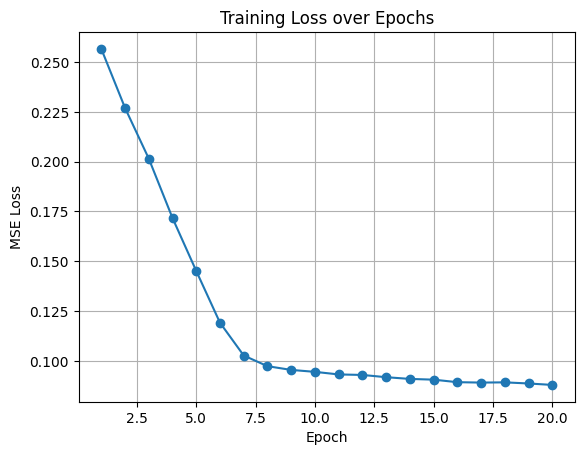

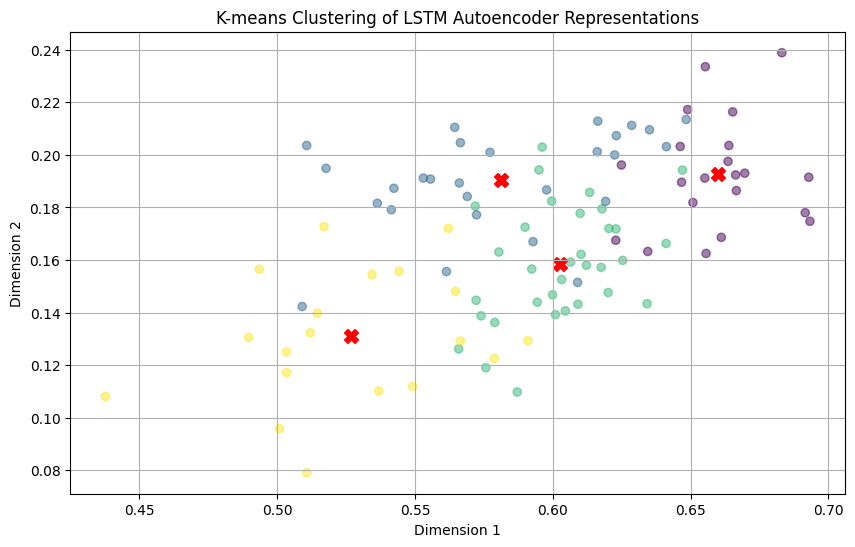

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Define the LSTM Autoencoder model
class LSTM_AE(nn.Module):
    def __init__(self, input_dim, hidden_dim, hidden_dim2, output_dim):
        super(LSTM_AE, self).__init__()

        self.hidden_dim = hidden_dim
        self.hidden_dim2 = hidden_dim2

        # Encoder LSTM
        self.encoder_lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)

        # Decoder LSTM
        self.decoder_lstm = nn.LSTM(hidden_dim, hidden_dim2, batch_first=True)

        # Output layer
        self.output_layer = nn.Linear(hidden_dim2, output_dim)

    def forward(self, x):
        # Encoder
        _, (h_n, _) = self.encoder_lstm(x)
        # Repeat the hidden state across the sequence length for the decoder
        h_n_repeated = h_n.repeat(x.size(1), 1, 1).permute(1, 0, 2)

        # Decoder
        decoded, _ = self.decoder_lstm(h_n_repeated)
        # Output layer to reconstruct input
        reconstructed = self.output_layer(decoded)

        return reconstructed

# Data generation
np.random.seed(42)
torch.manual_seed(42)

num_sequences = 100
sequence_length = 10
input_dim = 6

Data = np.random.rand(num_sequences, sequence_length, input_dim).astype(np.float32)
Time = np.random.randint(1, 10, size=(num_sequences, sequence_length)).astype(np.float32)

Data = torch.tensor(Data)
Time = torch.tensor(Time)  # Time is not used in the basic LSTM model

batch_size = 16
data_loader = torch.utils.data.DataLoader(Data, batch_size=batch_size, shuffle=True)

# Model initialization
hidden_dim = 16
hidden_dim2 = 16
output_dim = input_dim
model = LSTM_AE(input_dim, hidden_dim, hidden_dim2, output_dim)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
epochs = 20
losses = []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for x in data_loader:
        x = x.to(device)
        optimizer.zero_grad()
        reconstructed = model(x)
        loss = criterion(reconstructed, x)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(data_loader)
    losses.append(avg_loss)
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss}")


# Plot the training loss
plt.plot(range(1, epochs + 1), losses, marker='o')
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.show()


# Extract representations for clustering
model.eval()
data_reps = []

with torch.no_grad():
    for x in Data:
        x = x.unsqueeze(0).to(device)
        _, (h_n, _) = model.encoder_lstm(x)
        data_reps.append(h_n.cpu().numpy().reshape(-1, h_n.shape[-1]))

data_reps = np.vstack(data_reps)

# Perform K-means clustering
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(data_reps)
centroids = kmeans.cluster_centers_

# Visualize clustering
plt.figure(figsize=(10, 6))
plt.scatter(data_reps[:, 0], data_reps[:, 1], c=kmeans.labels_, cmap='viridis', alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=100)
plt.title("K-means Clustering of LSTM Autoencoder Representations")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True)
plt.show()
